In [1]:
import pandas as pd
from pandas.testing import assert_frame_equal
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

import seaborn as sns
%matplotlib inline

### First, we need to import the datasets.

In [2]:
boston_calendar_df = pd.read_csv('Data/boston_calendar.csv')
boston_listings_df = pd.read_csv('Data/boston_listings.csv')
boston_reviews_df = pd.read_csv('Data/boston_reviews.csv')
seattle_calendar_df = pd.read_csv('Data/seattle_calendar.csv')
seattle_listings_df = pd.read_csv('Data/seattle_listings.csv')
seattle_reviews_df = pd.read_csv('Data/seattle_reviews.csv')

In [3]:
boston_calendar_df.columns

Index(['listing_id', 'date', 'available', 'price'], dtype='object')

In [4]:
boston_listings_df.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'name',
 'summary',
 'space',
 'description',
 'experiences_offered',
 'neighborhood_overview',
 'notes',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'thumbnail_url',
 'medium_url',
 'picture_url',
 'xl_picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'street',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'city',
 'state',
 'zipcode',
 'market',
 'smart_location',
 'country_code',
 'country',
 'latitude',
 'longitude',
 'is_location_exact',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'bed_type',
 'amenities',


### Next, we need to make sure all columns are the same for both cities

In [5]:
calender_keep_rows = set(boston_calendar_df.columns.intersection(set(seattle_calendar_df)))
listings_keep_rows = set(boston_listings_df.columns.intersection(set(seattle_listings_df)))
reviews_keep_rows = set(boston_reviews_df.columns.intersection(set(seattle_reviews_df)))

In [6]:
def drop_cols(df, keep_cols):
    '''Function that removes columns from a dataframe
    Args:
        df (df): dataframe
        keep_cols ([str]): columns to keep
    Returns:
        df (df): df with only keep_cols columns
    '''
    drop_cols = list(set(df.columns)-set(keep_cols))
    df = df.drop(drop_cols, axis=1)
    
    return df

In [7]:
# calendar
boston_calendar_df = drop_cols(boston_calendar_df, calender_keep_rows)
seattle_calendar_df = drop_cols(seattle_calendar_df, calender_keep_rows)

# listings
boston_listings_df = drop_cols(boston_listings_df, listings_keep_rows)
seattle_listings_df = drop_cols(seattle_listings_df, listings_keep_rows)

# reviews
boston_reviews_df = drop_cols(boston_reviews_df, reviews_keep_rows)
seattle_reviews_df = drop_cols(seattle_reviews_df, reviews_keep_rows)

### Next, lets see what the data types are for each df.

In [8]:
print('Calendar: \n')
print('boston_df: \n', boston_calendar_df.dtypes)
print('\n seattle_df: \n', seattle_calendar_df.dtypes)
print('\n Listings: \n')
print('boston_df: \n', boston_listings_df.dtypes)
print('\n  seattle_df: \n', seattle_listings_df.dtypes)
print('\n Reviews: \n')
print('boston_df: \n', boston_reviews_df.dtypes)
print('seattle_df: \n', seattle_reviews_df.dtypes)


Calendar: 

boston_df: 
 listing_id     int64
date          object
available     object
price         object
dtype: object

 seattle_df: 
 listing_id     int64
date          object
available     object
price         object
dtype: object

 Listings: 

boston_df: 
 id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                                 object
                                     ...   
cancellation_policy                  object
require_guest_profile_picture        object
require_guest_phone_verification     object
calculated_host_listings_count        int64
reviews_per_month                   float64
Length: 92, dtype: object

  seattle_df: 
 id                                    int64
listing_url                          object
scrape_id                             int64
last_scraped                         object
name                             

### Now we need to convert some of the datatypes to a more usable form.

In [9]:
def cash_to_float(df, col):
    '''Function that converts a column from dollars to floats
    Args:
        df (df): dataframe
        col (str): column name
    Returns:
        df (df): original df with type cast to float
    '''
    #convert price to numerical
    df[col] = df[col].astype('str')
    df[col] = df[col].str.replace('$','')
    df[col] = df[col].str.replace(',','')
    df[col] = df[col].astype('float64')
    
    return df

In [10]:
def convert_calendar_df(calendar_df):
    '''Function that converts dtypes for the calender dfs
    Args:
        calender_df (df): df columns ['listing_id', 'date', 'available']
    Returns:"
        calender_df (df): df columns ['listing_id', 'date', 'available']
    '''
    # convert date to datetime
    calendar_df['date'] = pd.to_datetime(calendar_df['date'])
    # convert available to binary
    calendar_df['available'] = calendar_df['available'] == 't'
    calendar_df['available'] = calendar_df['available']*1
    #convert price to numerical
    calendar_df = cash_to_float(calendar_df, 'price')
    
    return calendar_df

In [11]:
def convert_listings_df(listings_df):
    '''Function that converts dtypes for the listings dfs
    Args:
        listings_df (df): df with listings info
    Returns:"
        listings_df (df): df columns ['listing_id', 'date', 'available']
    '''
    
    cash_columns = ['price', 'weekly_price','monthly_price','security_deposit','cleaning_fee', 'extra_people']
    
    float_columns = ['latitude', 'longitude','accommodates','bathrooms','bedrooms','beds','review_scores_rating','review_scores_accuracy',
                     'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
                     'review_scores_value', 'host_listings_count','square_feet','guests_included','minimum_nights','maximum_nights',
                    'availability_30','availability_60','availability_90','availability_365','calculated_host_listings_count',
                   'reviews_per_month']
    
    bool_columns = ['has_availability'] 
    str_columns = ['zipcode','host_about']
    date_columns = ['host_since']
    cat_columns = ['property_type','room_type','bed_type']
    
    # convert cash columns
    for col in cash_columns:
         listings_df = cash_to_float(listings_df, col)
        
    #convert float columns
    for col in float_columns:
        listings_df[col] = listings_df[col].astype('float64')
        
    #convert bool columns to 0/1
    for col in bool_columns:
        listings_df[col] = listings_df[col] == 'y'
        listings_df[col] = listings_df[col]*1
    
    #convert str columns
    for col in str_columns:
        listings_df[col] = listings_df[col].astype('str')
    
    #convert date columns
    for col in date_columns:
        listings_df[col] = pd.to_datetime(listings_df[col])
        
    # drop unnecessary columns
    keep_cols = [
        'id',
        'zipcode',
        'host_since',
        'host_about',
        'host_listings_count',
        'latitude',
        'longitude',
        'property_type',
        'room_type',
        'accommodates',
        'bathrooms',
        'bedrooms',
        'beds',
        'bed_type',
        'amenities',
        'square_feet',
        'price',
        'weekly_price',
        'monthly_price',
        'security_deposit',
        'cleaning_fee',
        'guests_included',
        'extra_people',
        'minimum_nights',
        'maximum_nights',
        'has_availability',
        'availability_30',
        'availability_60',
        'availability_90',
        'availability_365',
        'review_scores_rating',
        'review_scores_accuracy',
        'review_scores_cleanliness',
        'review_scores_checkin',
        'review_scores_communication',
        'review_scores_location',
        'review_scores_value',
        'calculated_host_listings_count',
        'reviews_per_month']
    
    listings_df = drop_cols(listings_df, keep_cols)
    
    # convert categorical columns to one hot vector encoding  
    for col in cat_columns:
        # append categorical df
        listings_df = pd.concat([listings_df, pd.get_dummies(listings_df[col])], axis=1)
        # drop original cat column
        listings_df.drop(col, axis=1, inplace=True)
    
    return listings_df

In [12]:
def convert_reviews_df(calender_df):
    '''Function that converts dtypes for the calender dfs
    Args:
        calender_df (df): df columns ['listing_id', 'date', 'available']
    Returns:"
        calender_df (df): df columns ['listing_id', 'date', 'available']
    '''
    calender_df['date'] = pd.to_datetime(calender_df['date'])
    calender_df['reviewer_name'] = calender_df['reviewer_name'].astype('str')
    calender_df['comments'] = calender_df['comments'].astype(str)
    
    return calender_df

### Convert dataframe dtypes

In [13]:
# convert dataframe dtypes
# calenders
boston_calendar_df = convert_calendar_df(boston_calendar_df);
seattle_calendar_df = convert_calendar_df(seattle_calendar_df);
# listings
boston_listings_df = convert_listings_df(boston_listings_df);
seattle_listings_df = convert_listings_df(seattle_listings_df);
# reviews
boston_reviews_df = convert_reviews_df(boston_reviews_df);
seattle_reviews_df = convert_reviews_df(seattle_reviews_df);

/home/qsherida/.local/lib/python3.6/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


### Lets examine the mean median and mode comparison of some columns for the two cities

#### price

In [14]:
boston_calendar_df.columns
boston_calendar_df['price'].describe()

count    643037.000000
mean        198.438909
std         180.142913
min          11.000000
25%          85.000000
50%         150.000000
75%         255.000000
max        7163.000000
Name: price, dtype: float64

In [15]:
seattle_calendar_df['price'].describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

#### capacity

In [16]:
boston_listings_df.columns
boston_listings_df['accommodates'].describe()

count    3585.000000
mean        3.041283
std         1.778929
min         1.000000
25%         2.000000
50%         2.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64

In [17]:
seattle_listings_df['accommodates'].describe()

count    3818.000000
mean        3.349398
std         1.977599
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        16.000000
Name: accommodates, dtype: float64

From this, wee can see that on average, it is about $60 more per night to rent an air BNB in Boston than in Seattle.  However, we can also see that on average, a unit in Seattle will accomodate more occupants.  It would be interesting to see how this looks in terms of per capita if wee assume a fully occupied unit.  To do this, we will need create a new column with price/accomodates.

In [18]:
# merge dfs
# create new colum price/accomodates
boston_listings_df['price_per_person']=boston_listings_df['price']/boston_listings_df['accommodates']
seattle_listings_df['price_per_person']=seattle_listings_df['price']/seattle_listings_df['accommodates']


# take column average 
boston_average_price_per_person = boston_listings_df[boston_listings_df['price'].notnull()]['price_per_person'].mean()
seattle_average_price_per_person = seattle_listings_df[seattle_listings_df['price'].notnull()]['price_per_person'].mean()

print(f'Boston average price per guest: {boston_average_price_per_person}')
print(f'Seattle average price per guest: {seattle_average_price_per_person}')

#drop columns after printing
boston_listings_df.drop('price_per_person', axis=1, inplace=True)
seattle_listings_df.drop('price_per_person', axis=1, inplace=True)


Boston average price per guest: 62.78624554470789
Seattle average price per guest: 41.26692308004841


In [19]:
# do price per person analysis on the Calende

We can see a fully occupied room in Seattle will be about 30% cheaper per guest.

#### review scores rating

In [20]:
boston_listings_df['review_scores_rating'].describe()

count    2772.000000
mean       91.916667
std         9.531686
min        20.000000
25%        89.000000
50%        94.000000
75%        98.250000
max       100.000000
Name: review_scores_rating, dtype: float64

In [21]:
seattle_listings_df['review_scores_rating'].describe()

count    3171.000000
mean       94.539262
std         6.606083
min        20.000000
25%        93.000000
50%        96.000000
75%        99.000000
max       100.000000
Name: review_scores_rating, dtype: float64

We can see that both of the cities have excellent review scors > %90 with Seattle reviews being slightly higher by about 2% on average.

### Lets check a heat map of the listings dataframe for each city

In [22]:
boston_listings_df_numerics = boston_listings_df.select_dtypes(['int64', 'float64'])
seattle_listings_df_numerics = seattle_listings_df.select_dtypes(['int64', 'float64'])

print(boston_listings_df_numerics.shape)
print(seattle_listings_df_numerics.shape)

diff_columns = set(boston_listings_df_numerics.columns)-set(seattle_listings_df_numerics.columns)
diff_columns

(3585, 32)
(3818, 32)


set()

In [23]:
def plot_corr(df_corr):
    '''Function to plot correlation heat map
    Args:
        df_corr (df) result of df.corr()
    Returns:
        None
    '''
    # calculate the correlation matrix
    #corr = df.corr()
    
    plt.figure(figsize=(16, 6))
    # plot the heatmap
    sns.heatmap(df_corr, 
            xticklabels=df_corr.columns,
            yticklabels=df_corr.columns)


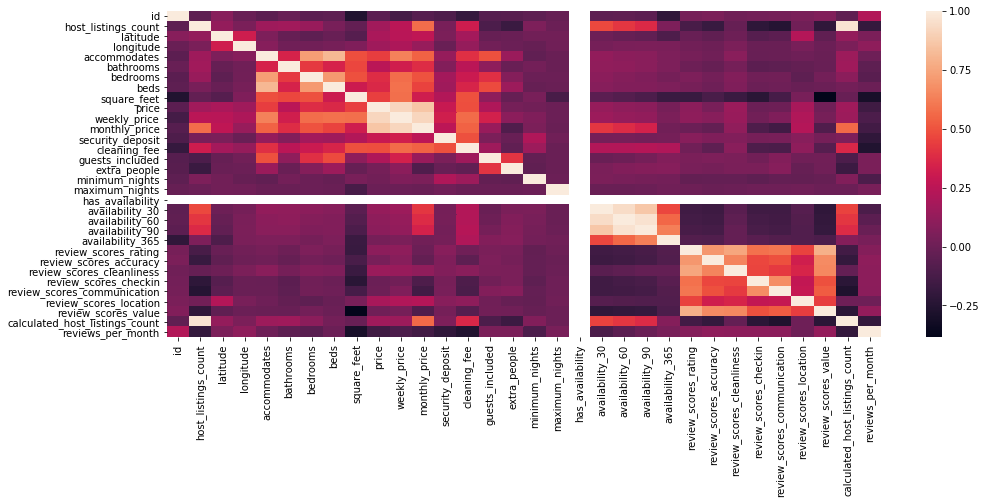

In [24]:
plot_corr(boston_listings_df_numerics.corr())

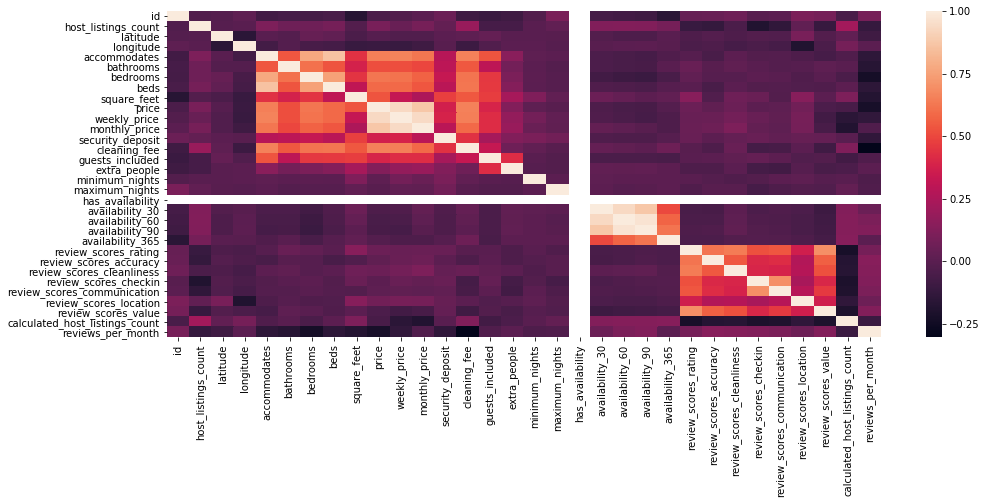

In [25]:
plot_corr(seattle_listings_df_numerics.corr())

In both cities we see an expected result: bedrooms, beds, sqaure feet, cleaning fee, guests included, and pricing are all correlated.  This makes since as wee would expect a larger room to have a higher cpacity, and as such it will have more beds, accomodate more people, and therefore fetch a hihgher asking price.

### Lets see if there are any intersting patterns in the differences between the two correlation heat maps

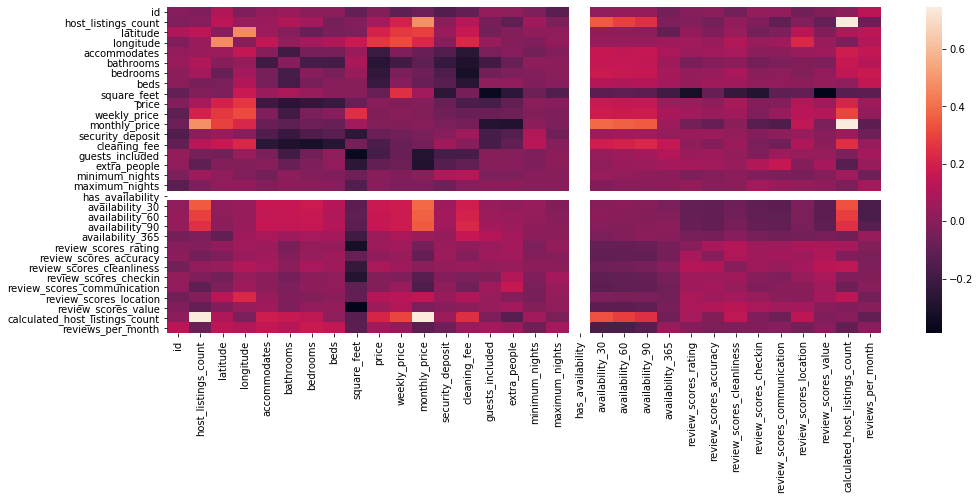

In [26]:
cols = boston_listings_df_numerics.columns
corr_diff = boston_listings_df_numerics.corr().values-seattle_listings_df_numerics.corr().values
corr_diff_df = pd.DataFrame(data=corr_diff, columns = cols)

plot_corr(corr_diff_df)


Between the two cities there are a few interesting differences.  Seattle has a higher correlation between the size of the air BNB and the security deposit.  This makes since due to the higher housing costs  and higher cost of living in Seattle relative to Boston.

#### Each city has about a years worth of data, but the data were taken during different intervals and we can not compare them as is, so we will extract the month from the date to compare them.


In [27]:
boston_calendar_df['month'] = pd.DatetimeIndex(boston_calendar_df['date']).month
seattle_calendar_df['month'] = pd.DatetimeIndex(seattle_calendar_df['date']).month

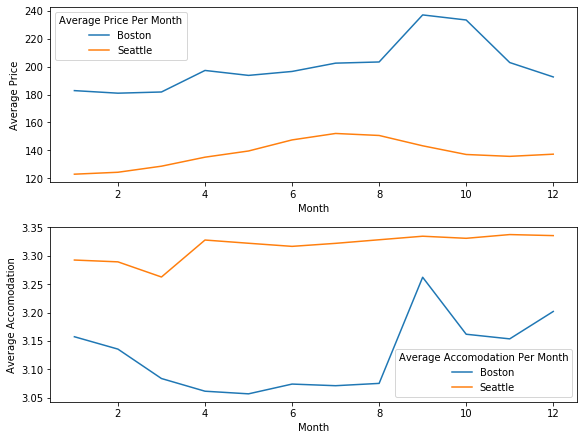

In [28]:
# plot price vs month for each city
boston_calendar_available = boston_calendar_df[boston_calendar_df['price'].notnull()]
seattle_calendar_available = seattle_calendar_df[seattle_calendar_df['price'].notnull()]

boston_monthly_price = boston_calendar_available.groupby('month').price.mean()
seattle_monthly_price = seattle_calendar_available.groupby('month').price.mean()


boston_calendar_rooms_available = pd.merge(boston_calendar_available, boston_listings_df,how='left', 
                                           left_on='listing_id' ,right_on='id').groupby('month')['accommodates'].mean()
seattle_calendar_rooms_available = pd.merge(seattle_calendar_available, seattle_listings_df,how='left', 
                                           left_on='listing_id' ,right_on='id').groupby('month')['accommodates'].mean()

boston_monthly_price = boston_calendar_available.groupby('month').price.mean()
seattle_monthly_price = seattle_calendar_available.groupby('month').price.mean()

fig, ax = plt.subplots(2,figsize=(8, 6),constrained_layout=True)

ax[0].plot(boston_monthly_price.index, boston_monthly_price.values, label='Boston')
ax[0].plot(seattle_monthly_price.index, seattle_monthly_price.values, label='Seattle')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Average Price')
ax[0].legend(title='Average Price Per Month')

ax[1].plot(boston_monthly_price.index, boston_calendar_rooms_available.values, label='Boston')
ax[1].plot(seattle_monthly_price.index, seattle_calendar_rooms_available.values, label='Seattle')
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Average Accomodation')
ax[1].legend(title='Average Accomodation Per Month')
#secaxy = ax.secondary_yaxis('right')
#secaxy.set_ylabel(r'$T\ [^oF]$')

For the data set given, we can see that both cities experience minimum AirBNB pricing during January.  Pricing in Seattle peaks during July whereas pricing in Boston peaks during November.  The average room price clearly changes a lot during the year.  Choosing your booking time can save you upt to 30% so it is worth while to plan ahead.

The average accomodation size is larger for Seattle in all months.  The average accomodation of Seattle is fairly constant throughout the year while Boston sees a sharp increase in december.

## Lets try to fit a model to predict the price of a unit in each city at a given time

### Get the Data

In [29]:
from sklearn.model_selection import train_test_split


In [30]:
# drop 'price' from listings, price will be taken from the calender df to examine price over time
boston_listings_df_numerics.drop('price', axis=1, inplace=True)
seattle_listings_df_numerics.drop('price', axis=1, inplace=True)

# merge the listings df with the calendar df, keep the calendar value
boston_df = boston_calendar_df.merge(right=boston_listings_df_numerics, how='left', left_on = 'listing_id', right_on='id')
boston_df = boston_df.drop(['listing_id', 'date', 'available'],axis=1,  inplace=False)
seattle_df = seattle_calendar_df.merge(right=seattle_listings_df_numerics, how='left', left_on = 'listing_id', right_on='id')
seattle_df = seattle_df.drop(['listing_id', 'date', 'available'],axis=1, inplace=False)
boston_df

/home/qsherida/.local/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,price,month,id,host_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,...,availability_365,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,reviews_per_month
0,NaN,9,12147973,1.0,42.282619,-71.133068,4.0,1.5,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1,NaN,9,12147973,1.0,42.282619,-71.133068,4.0,1.5,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
2,NaN,9,12147973,1.0,42.282619,-71.133068,4.0,1.5,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
3,NaN,9,12147973,1.0,42.282619,-71.133068,4.0,1.5,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,NaN,9,12147973,1.0,42.282619,-71.133068,4.0,1.5,2.0,3.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308885,NaN,9,14504422,14.0,42.387888,-71.080654,2.0,1.0,1.0,1.0,...,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1308886,NaN,9,14504422,14.0,42.387888,-71.080654,2.0,1.0,1.0,1.0,...,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1308887,NaN,9,14504422,14.0,42.387888,-71.080654,2.0,1.0,1.0,1.0,...,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1308888,NaN,9,14504422,14.0,42.387888,-71.080654,2.0,1.0,1.0,1.0,...,165.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN


### Examine the Data

In [31]:
# check to see if either sity has missing values for 'date' column as this will be central to our model
bd_nulls = boston_df['month'].isnull().sum()
sd_nulls = seattle_df['month'].isnull().sum()

if bd_nulls > 0:
    print(f"Boston has {bd_nulls} missing values for 'date'.")

if sd_nulls > 0:
    print(f"Seattle has {sd_nulls} missing values for 'date'.")



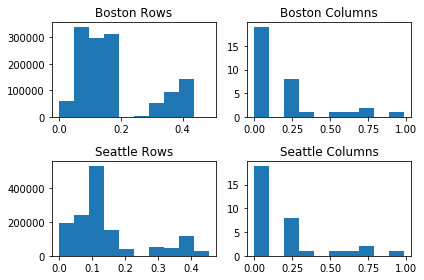

In [32]:
# make a histogram of how many values are missing in the columns and rows of our data
b_nulls_df =  boston_df.isnull()
s_nulls_df = seattle_df.isnull()

# rows
b_row_null = b_nulls_df.sum(axis=1)/b_nulls_df.shape[1]
s_row_null = s_nulls_df.sum(axis=1)/s_nulls_df.shape[1]

# columns
b_col_null = b_nulls_df.sum()/b_nulls_df.shape[0]
s_col_null = b_nulls_df.sum()/b_nulls_df.shape[0]
    

# make histogram plots of %null
f, ([ax1, ax2], [ax3, ax4]) = plt.subplots(2, 2, sharey=False)
ax1.hist(b_row_null)
ax1.set_title('Boston Rows')
ax3.hist(s_row_null)
ax3.set_title('Seattle Rows')
ax2.hist(b_col_null)
ax2.set_title('Boston Columns')
ax4.hist(s_col_null)
ax4.set_title('Seattle Columns')
f.tight_layout()




We can see that the two cities have some slight differences in what information has been provided by the reviews but in general it seems as though each city has roughly the same sparseness in the data.

### Prep the Data


In [33]:
def get_time_data(df, type):
    '''Function that returns a df for test/training data
    Args:
        boston_df (df): df with Boston data
        seattle_df (df): df with Seattle data
        type (str): type of time representation, on of ['cat', seq', 'catseq']
            cat - treat time as categorical by month
            seq - treat time as a sequence using sin(2pi*m/12) tranformation
            ctaseq - use both cat and seq representations        
    Returns:
        df (df): df with new time columns for modeling
    '''
    new_df = df.copy()
    
    # treating time as a sequence
    if type == 'seq':
        new_df['time'] = new_df['month'].apply(lambda x: np.sin(2*np.pi*x/12))      
    
    elif type == 'catseq' or type == 'cat':
        # convert month to categorical
        month_dummies = pd.get_dummies(new_df['month'])
        new_df = pd.concat([new_df,month_dummies], axis=1)
        
        if type == 'catseq':
            # add sequencial transformation
            new_df['time'] = new_df['month'].apply(lambda x: np.sin(2*np.pi*x/12))  
    
    else:
        raise NameError("get_time_data() invalid option for 'type', use one of ['cat', seq', 'catseq']")
                        
    return new_df


### Clean the Data

We need to clean our data up prior to model training and testing.  We will want to remove sparse rows and columns.  If we have too many imputed values in our data, it will skew our models predictions and we will not correctly capture variable relationships.

In [34]:
def clean_df(original_df, row_min=0.4, col_min=0.6):
    '''Function that evaluates how sparse a df is and removes sparse rows and 
            columns to give better ML model data
        Args:
            original_df (df): df with uncleaned, intial ML data
            row_min (float): acceptable percentage of row Nulls
            col_min (float)": acceptable percentage of column Nulls
        Returns:
            new_df (df): copy of original_df withrows and columns cleaned
    '''
    # remove columns
    percent_null = original_df.isnull().sum()/original_df.shape[0]
    drop_cols = percent_null[percent_null>col_min].index.values
    new_df = original_df.drop(drop_cols, axis=1)
    # remove rows
    drop_rows = new_df[new_df.isnull().sum(axis=1) > row_min].index.values
    new_df = new_df.drop(drop_rows, axis=0)
        
    return new_df

### Impute Missing Values

We want to use as much data as possible to improve our model performance.  We know that there is a time dependence to our model that we would like to capture.  Therefore, we will impute month based mean values for any missing values in our model to try and give a simple but representative mean value for the missing values. 

In [35]:
def impute_values(df): 
    '''Function that imputes monthly mean values for missing values in a df
    Args:
        df (df): df with missing values
    Returns:
        df (df): df with missing values imputed 
    '''
    for i in range(12):
        df[df['month']==i+1] = df[df['month']==i+1].fillna(df[df['month']==i+1].mean())
            
    return df     

In [36]:
impute_test = pd.DataFrame({'a':[1,2,None,None,4,5, 1,None,None,None,4,5], 'b':[0, 10,None,30,40,50,0, 10,None,30,40,50],
                    'month':[1,1,1,1,1,1,2,2,2,2,2,2]})
impute_test = impute_values(impute_test)

assert_frame_equal(impute_test, pd.DataFrame({'a':[1.0,2.0,3.0,3.0,4.0,5.0,1.0,3.3333333,3.3333333,3.3333333,4.0,5.0], 
                                        'b':[0.0,10.0,26.0,30.0,40.0,50.0,0.0,10.0,26.0,30.0,40.0,50.0], 
                                        'month':[1,1,1,1,1,1,2,2,2,2,2,2]}))

### Perform Mean Normalization Feature Scaling

In [37]:
def normalize_features(X_train):  
    X_scaled = preprocessing.scale(X_train)
    return X_scaled
    

### Split Into Test and Training

In [38]:
def test_train_data(df, y_column):
    '''Function to get test and train data
    Args:
        df (df): dataframe
        columns ([str]): subset of df to use
    Returns
        X_train, X_test, y_train, y_test: test train data split
    '''
    # get columns that will be used in our model
    y = df[y_column].values
    # remove columns that won't be used in the model
    drop_columns = ['month', 'id', 'host_listings_count', 
                'weekly_price', 
                'monthly_price', 'security_deposit', y_column]
    
    X = df.drop(drop_columns, axis=1).values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
    
    return X_train, X_test, y_train, y_test


### Fit the Model

In [39]:
a = [1,2,3,4]
b = [1,2,3,4]

np.multiply(a,b)

array([ 1,  4,  9, 16])

In [40]:
def fit_evaluate_linear_model(df, time_type, y_col='price'):
    '''Function that fits a linear regression model and evaluates the R2 of the model performance
    Args:
       df (dataframe)": dataframe for model
       time_type (str): type of time representation, on of ['cat', seq', 'catseq']
            cat - treat time as categorical by month
            seq - treat time as a sequence using sin(2pi*m/12) tranformation
            ctaseq - use both cat and seq representations  
    Returns:
        lm_model (sklearn model):fitted linear regression model
        mse (float): model mean squared error
        R2(float)": model R squared
    '''
    
    # make time representation of month
    df = get_time_data(df, time_type)
    # impute_missing_values
    df = impute_values(df)
    # get train/test data sets
    X_train, X_test, y_train, y_test = test_train_data(df, y_col)
    
    # initiate model
    lm_model = LinearRegression(normalize=True) 

    # fit 
    lm_model.fit(X_train, y_train) 
    
    # predict values
    y_pred = lm_model.predict(X_test)
    # get mean squarred error
    mse = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    
    return lm_model, mse, R2


### Putting It All Together

In [41]:
def main():
    # clean original datasets
    model_boston_df = clean_df(boston_df, row_min=0.8, col_min=0.8)
    model_seattle_df = clean_df(seattle_df, row_min=0.8, col_min=0.8)
    
    # fit each of the three time models for each city and report the results
    time_types = ['cat', 'seq', 'catseq']
    #time_types = ['cat']
    
    print('Boston Model Evaluation')
    #Boston
    for time_type in time_types:
        # make time representation of month
        lm_model, mse, R2 = fit_evaluate_linear_model(model_boston_df, time_type)
        print('time type: ', time_type, 'MSE: ', mse, 'R2: ', R2)
        
    print('Seattle Model Evaluation')
    #Boston
    for time_type in time_types:
        # make time representation of month
        lm_model, mse, R2 = fit_evaluate_linear_model(model_seattle_df, time_type)
        print('time type: ', time_type, 'MSE: ', mse, 'R2: ', R2)
        
    
        

In [42]:
main()

Boston Model Evaluation
time type:  cat MSE:  4872.5097959167115 R2:  0.6999049769660759
time type:  seq MSE:  4918.324049329934 R2:  0.697083303945563
time type:  catseq MSE:  4872.381562783655 R2:  0.699912874769596
Seattle Model Evaluation
time type:  cat MSE:  4026.674308090629 R2:  0.5771962899504524
time type:  seq MSE:  4068.26737620269 R2:  0.5728289877639337
time type:  catseq MSE:  4026.6685368961835 R2:  0.5771968959300364
